In [1]:
import sqlite3
import pandas as pd
import pathlib
import json
import re
from tqdm import tqdm
from bertopic import BERTopic
import pickle
import bz2
from tqdm.contrib.concurrent import process_map
from collections import defaultdict
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import stats
import arviz as az
from itertools import cycle
from scipy.stats import bernoulli
import random
from operator import concat
from functools import reduce

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


see get_seeded_mp.py for the script to pull comments from the reddit data wrt., seed terms

see cut_comments which takes the comments.json and indices.json output from get_seeded_mp.py and extracts, for this analysis, the 2015 'poor comments'

see topic_model.py which performs topic modelling on the above 2015 poor comments subset. see the script for details

In [2]:
import sys
sys.version

'3.11.6 (main, Nov  2 2023, 04:39:43) [Clang 14.0.3 (clang-1403.0.22.14.1)]'

## Load comments, indices, config

In [11]:
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

In [3]:
with open('comments.json', 'r', encoding='utf-8') as f:
    comments = json.load(f)

In [4]:
with open('indices.json', 'r', encoding='utf-8') as f:
    indices = json.load(f)
indices = {k:[tuple(p) for p in indices[k]] for k in tqdm(indices.keys())}

100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 176.90it/s]


## Load the topic_model

In [5]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic.load("topic_model.safetensors", embedding_model=embedding_model)

2024-03-13 10:25:19,751 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model.If you want to also load in an embedding model, make sure to useBERTopic.load(my_model, embedding_model=my_embedding_model).


## get a dataframe of topics wrt., all comments

In [6]:
ordered_comments = reduce(concat, [comments[seed] for seed in comments.keys()])
df_topic = topic_model.get_document_info(ordered_comments)

In [7]:
df_topic.shape

(1904437, 7)

## collapse rows which are the same comment (have the same comment index)

In [8]:
df_topic['index'] = [index for seed in indices.keys() for index in indices[seed]]
df_topic = df_topic.drop_duplicates(subset=['index'], keep='first')

In [9]:
df_topic.shape

(1830354, 8)

## rows by context type

In [12]:
poor_indices = set([index for seed in config['wealth_seeds']['poor_seeds'] for index in indices[seed]])
rich_indices = set([index for seed in config['wealth_seeds']['rich_seeds'] for index in indices[seed]])
neutral_indices = set(indices['neutral_sample'])
black_indices = set([index for seed in config['other_seeds']['black_seeds'] for index in indices[seed]])
n_indices = set([index for seed in config['other_seeds']['n_seeds'] for index in indices[seed]])

In [13]:
display(len(poor_indices.intersection(rich_indices)))
display(len(poor_indices.intersection(black_indices)))
display(len(neutral_indices.intersection(black_indices)))
display(len(poor_indices.intersection(n_indices)))
display(len(neutral_indices.intersection(n_indices)))

14397

4395

995

413

290

# RQ1

In [14]:
RQ1_selected = [
    '16_prison_jail_court_lawyer',
    '37_fat_fat people_weight_obese',
]

# Examine relative proportions of selected topics (deemed negative in their association)

In [15]:
# pure poor_context indices (as not coincident with rich) and vice-versa
poor_indices_pure = poor_indices - rich_indices
rich_indices_pure = rich_indices - poor_indices

In [16]:
for name in RQ1_selected:  # topics
    c_rich = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)) & (df_topic.loc[:, 'Name']==name), :])
    c_poor = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, 'Name']==name), :])
    c_neutral = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(neutral_indices)) & (df_topic.loc[:, 'Name']==name), :])
    # print('rich', name, c_rich)
    # print('poor', name, c_poor)
    print(f'risk ratio point estimate: P(poor,{name}) / P(rich,{name}) = {c_poor*len(rich_indices_pure)/(c_rich*len(poor_indices_pure))}')
    print(f'risk ratio point estimate: P(poor,{name}) / P(neutral,{name}) = {c_poor*len(neutral_indices)/(c_neutral*len(poor_indices_pure))}')

    print('\n')


risk ratio point estimate: P(poor,16_prison_jail_court_lawyer) / P(rich,16_prison_jail_court_lawyer) = 0.6357952253428707
risk ratio point estimate: P(poor,16_prison_jail_court_lawyer) / P(neutral,16_prison_jail_court_lawyer) = 1.7636509489565706


risk ratio point estimate: P(poor,37_fat_fat people_weight_obese) / P(rich,37_fat_fat people_weight_obese) = 1.5672993851728032
risk ratio point estimate: P(poor,37_fat_fat people_weight_obese) / P(neutral,37_fat_fat people_weight_obese) = 2.219051669860016




# Bayesian estimation wrt., binomial outcomes

## helper functions

In [17]:
def plot_posterior_estimates(trace):
    """ Plot posterior parameter distributions, i.e., P(parameter=value | data)
    """
    var_names = [name for name in trace.posterior]
    for i, var_name in enumerate(var_names):
        az.plot_trace(data=trace, var_names=[var_name])
    
def plot_posterior_predictive_checks(model, trace, size=1000):
    """ Plot (hist) predictions of estimand (based on parameter posteriors) against the observed 
    """
    
    # get estimand predictions based on param posteriors
    with model: 
        post_pred: arviz.data.inference_data.InferenceData = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        # don't add to trace
            
    # for each estimate record (predictions, observed) for each estimand
    d = {}
    n = len(post_pred.posterior_predictive)
    for i, name in enumerate(post_pred.posterior_predictive):
        
        # get a random sample (with replacement) of predictions from stack predictions accross draws and chains
        p_dims = post_pred.posterior_predictive[name].dims
        p: np.ndarray = np.random.choice(post_pred.posterior_predictive[name].stack(sample=p_dims).to_numpy(), size, replace=True)
            
#         p: xarray.core.dataarray.DataArray = post_pred.posterior_predictive[name].mean(sample=('chain', 'draw'))  
            
        o: np.ndarray = post_pred.observed_data[name].to_numpy()
        d[name] = (p,o)  # (predicted, observed)
        
    # plot observed vs predicted for each estimand
    fig, axs = plt.subplots(n)
    fig.tight_layout(h_pad=4)
    for i, name in enumerate(post_pred.posterior_predictive):

        if n > 1:
            plt.sca(axs[i])
        else:
            pass
        plt.hist([d[name][0], d[name][1]], label=['predicted', 'observed'], density=True)
        plt.xlabel(name)
        plt.ylabel("density")
        plt.legend()
        plt.xticks(rotation=90)
        
    return d
    
def plot_posterior_estimates_contrast(trace, pairs=[], kind='kde'):
    """ For each param1, param2 pair in 'pairs' ...
            plot distribution of corresponding (param1 - param2) estimates.
            
        Note: also return each pair contrast. I.e., returned[i] is a contrast dist. corresponding to pairs[i]
    """
    contrasts = []
    
    fig, axs = plt.subplots(1)
    fig.tight_layout()
    
    # plot contrasts
    for i, (x,y) in enumerate(pairs):
        
        pc = (trace.posterior[x] - trace.posterior[y]).stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        az.plot_dist(pc, color=f'C{i}', kind=kind, label=f'{x}-{y}')
        
        contrasts.append(pc)
        
    plt.xlabel(f"posterior estimates contrast")
    plt.ylabel("density")
    plt.legend()
        
    return contrasts
        
        
def plot_posterior_predictions_contrast(model, trace, pairs=[], size=1000)->list:
    """ For each estimand1, estimand2 'pair' in 'pairs' ...
            plot the distribution of corresponding (estimand1 - estimand2) samples
    
        Note: also return each contrast. I.e., returned[i] is a contract dist. corresponding to pairs[i]
        where returned 1 is a 1D numpy array
    """
    
    returned=[]
    
    # get posterior predictions
    with model:
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
    preds = {name: post_pred.posterior_predictive[name] for name in post_pred.posterior_predictive} 
    # NOTE: e.g., preds[var].shape=(chains, draws, datapoints)
        
    fig, axs = plt.subplots(len(pairs))
    fig.tight_layout()
    
    
    for i, (name1, name2) in enumerate(pairs):
        
        # if more than one plot, set current
        try:
            plt.sca(axs[i])
        except:
            pass
        
        # Note xarray of dims (chain, draw, m) - x array of dims (chain, draw, f) would yield an
        # an array of dims (chain, draw, m, f) i.e., all possible differences accross all m,f permutations for a draw, chain combo
        # this becomes very slow for larger samples ... hence we just randomnly select some ... and take the diff.
        
        # plot contrast
        sample1 = np.random.choice(preds[name1].stack(sample=(preds[name1].dims)).to_numpy(), size, replace=True)
        sample2 = np.random.choice(preds[name2].stack(sample=(preds[name2].dims)).to_numpy(), size, replace=True)
        ppc = sample1 - sample2
        az.plot_dist(ppc, color='k', plot_kwargs=dict(linewidth=3))
        plt.xticks(rotation=90)
        
        plt.xlabel(f"({name1}-{name2})\nposterior prediction contrast")
        plt.ylabel("density")
        plt.legend()
        
        returned.append(ppc)
        
    return returned

def compat_interval(d: np.ndarray, CI=0.89)->tuple[float]:
    lb = (1-CI)/2
    ub = CI+lb
    return '%.3E' % np.quantile(d, lb), '%.3E' % np.quantile(d, ub)



### Estimator

In [18]:
RQ1_selected

['16_prison_jail_court_lawyer', '37_fat_fat people_weight_obese']

In [19]:
def estimator(n, s):
    
    with pm.Model() as model:
                    
        # prior
        param = pm.LogitNormal(f'param', 0, 1.5)
        
        # likelihood
        pm.Binomial(f"likelihood", n = n , p=param, observed=s)
        
        trace=pm.sample()
        
    return model, trace


# test
for name in RQ1_selected:

    # poor
    n = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)), :])
    s = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, 'Name']==name), :])
    model_poor, trace_poor = estimator(n, s);
    p_poor = trace_poor.posterior[f'param'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

    # rich
    n = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)), :])
    s = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)) & (df_topic.loc[:, 'Name']==name), :])
    model_rich, trace_rich = estimator(n, s);
    p_rich = trace_rich.posterior[f'param'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
    
    # neutral
    n = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(neutral_indices)), :])
    s = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(neutral_indices)) & (df_topic.loc[:, 'Name']==name), :])
    model_neutral, trace_neutral = estimator(n, s);
    p_neutral = trace_neutral.posterior[f'param'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
    
    ## posterior contrasts

    pc_poor_rich = p_poor / p_rich
    print(name, 'poor/rich', np.percentile(pc_poor_rich, 0.05), np.percentile(pc_poor_rich,99.5))
          
    pc_poor_neutral = p_poor / p_neutral
    print(name, 'poor/neutral', np.percentile(pc_poor_neutral, 0.05), np.percentile(pc_poor_neutral,99.5))
    
    pc_rich_neutral = p_rich / p_neutral
    print(name, 'rich/neutral', np.percentile(pc_rich_neutral, 0.05), np.percentile(pc_rich_neutral,99.5))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


16_prison_jail_court_lawyer poor/rich 0.5607095472021207 0.7050829011784606
16_prison_jail_court_lawyer poor/neutral 1.562027052380525 1.9351773935908387
16_prison_jail_court_lawyer rich/neutral 2.522754451446042 2.9930481992105147


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


37_fat_fat people_weight_obese poor/rich 1.3274526176029844 1.810156623658033
37_fat_fat people_weight_obese poor/neutral 1.9269675172743528 2.4979015832326983
37_fat_fat people_weight_obese rich/neutral 1.2171940340663852 1.6032836426456374


### Plot

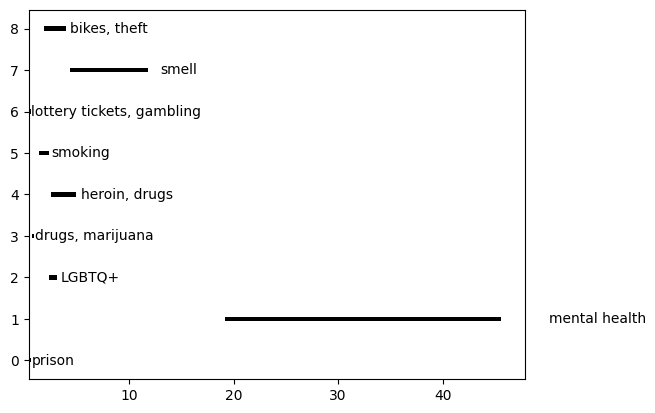

In [80]:
# fig, axs = plt.subplots(len(topics_), figsize=[10,10])

fig, ax = plt.subplots()

# get 99% CI as lower bound and upper bound
bars = []
for i, (tl, tn) in enumerate(topics_):
    
    # get contrasts
    p_poor = trace.posterior[f'p_poor_{tl}'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
    p_rich = trace.posterior[f'p_rich_{tl}'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

    pc = p_poor/p_rich
    bars.append([np.percentile(pc, 0.05), np.percentile(pc,99.5), i, tl])

# Plot each bar
for bar in bars:
    # Extract coordinates for each bar and its height
    x1, x2, y, label= bar
    width = x2 - x1
    ax.barh(y, width, left=x1, color='black', height=0.1, label=label )

    if tl in ['mental health']:
        ax.text(x2*1.1, y, label, ha='right', va='center', color='black')
    else:
        ax.text(x2*1.1, y, label, ha='left', va='center', color='black')